В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x, n_1):
        W1 = np.random.randn(n_1, n_x) * 0.01
        b1 = np.zeros((n_1, 1))
        W2 = np.random.randn(1, n_1) * 0.01
        b2 = 0 # у вихідному шарі лише 1 нейрон
        self.parameters = {"W1" : W1, "b1" : b1, "W2" : W2, "b2" : b2}
       
    def __forward_propagation(self, X):
        W1 = self.parameters["W1"]
        b1 = self.parameters["b1"]
        W2 = self.parameters["W2"]
        b2 = self.parameters["b2"]

        Z1 = np.dot(W1, X) + b1
        A1 = self.__sigmoid(Z1)

        Z2 = np.dot(W2, A1) + b2
        A2 = self.__sigmoid(Z2)

        
        cache = (W1, b1, W2, b2, Z1, A1, Z2, A2)

        return A2, cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W1, b1, W2, b2, Z1, A1, Z2, A2) = cache
        
        dZ2 = A2 - Y
        dW2 = 1. / m * np.dot(dZ2, A1.T)
        db2 = 1. / m * np.sum(dZ2, axis = 1, keepdims = True)
        
        dA1 = np.dot(W2.T, dZ2)
        dZ1 = np.multiply(dA1, np.multiply(A1, 1 - A1))
        dW1 = 1. / m * np.dot(dZ1, X.T)
        db1 = 1. / m * np.sum(dZ1, axis = 1, keepdims = True)
        

        grads = {"dZ1" : dZ1, "dW1" : dW1, "db1" : db1, "dZ2" : dZ2, "dW2" : dW2, "db2" : db2}
        return grads
    
    def __update_parameters(self, grads):
        W1 = self.parameters["W1"]
        b1 = self.parameters["b1"]
        W2 = self.parameters["W2"]
        b2 = self.parameters["b2"]

        dW1 = grads["dW1"]
        db1 = grads["db1"]
        dW2 = grads["dW2"]
        db2 = grads["db2"]
        

        self.parameters["W1"] = W1 - self.learning_rate * dW1
        self.parameters["b1"] = b1 - self.learning_rate * db1
        self.parameters["W2"] = W2 - self.learning_rate * dW2
        self.parameters["b2"] = b2 - self.learning_rate * db2

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x, 20)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [5]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, Y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [6]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


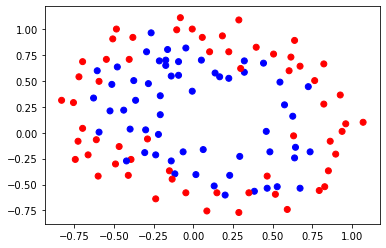

In [7]:
plot_data(X, Y)

In [8]:
cls = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 4000)

0-th iteration: 0.6932132845613251
1000-th iteration: 0.6901256594893714
2000-th iteration: 0.6721612524845662
3000-th iteration: 0.5753242836867241


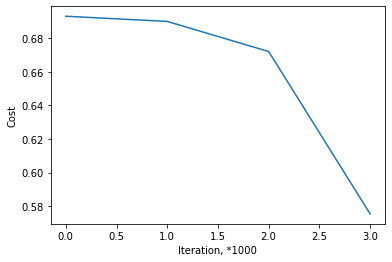

In [9]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [10]:
print(cls.parameters)

{'W1': array([[ 0.51024666,  0.26025267],
       [ 3.71796429,  2.6505536 ],
       [-0.02149411,  0.0399349 ],
       [ 0.38603485,  0.18861644],
       [-2.34784104,  1.8052009 ],
       [-0.31681927, -0.0358632 ],
       [ 0.59531884,  0.22958017],
       [ 0.76415875,  0.61629523],
       [ 0.7998777 ,  0.68361252],
       [-0.51879368, -0.20214098],
       [ 0.24757422,  0.13825363],
       [ 0.76007727,  0.65219472],
       [-0.16080731, -0.01778241],
       [-0.55053416, -0.19744229],
       [ 0.34856594,  0.15509794],
       [ 0.49825212,  0.20430097],
       [-0.09014138,  0.01685766],
       [ 0.4665711 ,  0.18553704],
       [ 0.36290072,  3.10626099],
       [-0.16546946, -1.69592173]]), 'b1': array([[ 2.19293775e-01],
       [-3.38219314e+00],
       [ 9.96993443e-03],
       [ 7.89793726e-02],
       [-3.18754547e+00],
       [-3.44440364e-02],
       [ 2.71664758e-01],
       [ 7.28564542e-01],
       [ 8.18472541e-01],
       [-2.77190047e-01],
       [ 6.77266750e-03],

In [11]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.55542096, 0.44457904],
       [0.59487582, 0.40512418],
       [0.20977971, 0.79022029],
       [0.26250048, 0.73749952],
       [0.20274038, 0.79725962],
       [0.84463668, 0.15536332],
       [0.15566723, 0.84433277],
       [0.42510471, 0.57489529],
       [0.73753335, 0.26246665],
       [0.89566905, 0.10433095],
       [0.90042672, 0.09957328],
       [0.42472236, 0.57527764],
       [0.25538932, 0.74461068],
       [0.26934178, 0.73065822],
       [0.64240034, 0.35759966],
       [0.39855837, 0.60144163],
       [0.4239524 , 0.5760476 ],
       [0.78609571, 0.21390429],
       [0.50641125, 0.49358875],
       [0.25797623, 0.74202377],
       [0.96325887, 0.03674113],
       [0.82897924, 0.17102076],
       [0.69407852, 0.30592148],
       [0.14806541, 0.85193459],
       [0.35712596, 0.64287404],
       [0.78861262, 0.21138738],
       [0.36943342, 0.63056658],
       [0.46434783, 0.53565217],
       [0.33850884, 0.66149116],
       [0.63294258, 0.36705742],
       [0.

In [12]:
Y_hat = cls.predict(X)
Y_hat

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0])

In [13]:
accuracy_score(Y, Y_hat)

0.8135593220338984

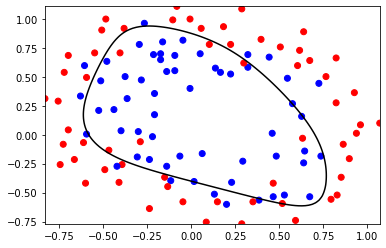

In [14]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [30]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000)#, activation = 'logistic', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [31]:
clf.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

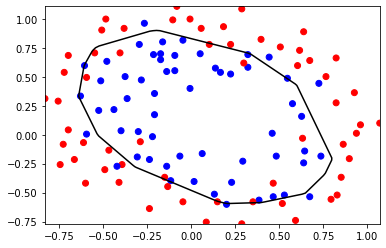

In [32]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [33]:
accuracy_score(Y, clf.predict(X))

0.847457627118644

In [34]:
clf.n_iter_

1252